In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

import time, os, random
from datetime import timedelta

! killall tensorboard
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

/home/denis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load

In [2]:
X = np.load('data/X.npy')
y = np.load('data/y.npy')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
del X,y
temp = y_train.shape
y_train = y_train.reshape(temp[0], 1)
y_train = np.concatenate((1-y_train, y_train), axis=1)
temp = y_test.shape
y_test = y_test.reshape(temp[0], 1)
y_test = np.concatenate((1-y_test, y_test), axis=1)

## Data Dimensions and split

In [4]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(X_train)))
print("- Test-set:\t\t{}".format(len(X_test)))

Size of:
- Training-set:		205548
- Test-set:		68517


In [6]:
img_size = 40
num_input = 58 * img_size

img_size_flat = 58 * img_size * 3

# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_channels = 3
num_classes = 2
classes = ['Not occupied', 'Occupied']
dropout = 0.25 # Dropout, probability to drop a unit

early_stopping = None 

## Helper-function
### Ploting

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(58, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            if len(cls_true[0]) == 2:
                xlabel = "True: {0}".format(classes[cls_true[i][1]])
            else:
                xlabel = "True: {0}".format(classes[cls_true[i]])
        else:
            if len(cls_true[0]) == 2:
                xlabel = "True: {0}, Pred: {1}".format(classes[cls_true[i][1]], classes[cls_pred[i]])
            else:
                xlabel = "True: {0}, Pred: {1}".format(classes[cls_true[i]], classes[cls_pred[i]])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

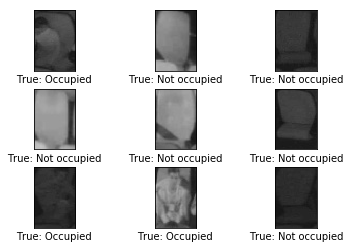

In [8]:
# Plot the images and labels using our helper-function above.
plot_images(images=X_test, cls_true=y_test)

## Tensorflow setup and run

In [9]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [10]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [11]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [12]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [13]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, 58, img_size, 3])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [14]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

fc_size = 128  

In [15]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

In [16]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [17]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [18]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [19]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [20]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [22]:
train_batch_size = batch_size

In [23]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

In [24]:
def make_batch(x, y, batch_size):
    rand_index = np.random.choice(x.shape[0], size=batch_size)
    x_batch, y_batch = x[rand_index], y[rand_index]
    # Do all your pre-processing here
    # ...
    return (x_batch, y_batch)

In [25]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = make_batch(X_train, y_train, train_batch_size)
        x_valid_batch, y_valid_batch = make_batch(X_test, y_test, train_batch_size)
        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(len(X_train)/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(len(X_train)/batch_size))
            
            print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [26]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images,
                cls_true=cls_true,
                cls_pred=cls_pred)

In [27]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = [y_test[i][1] for i in range(len(y_test))]
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [28]:
def print_validation_accuracy(show_example_errors=False,
                              show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(X_test)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    for i in tqdm_notebook(range(0, num_test-batch_size, batch_size)):
        j= i+batch_size
        # Get the images from the test-set between index i and j.
        images = X_test[i:j, :].reshape(batch_size, img_size_flat)
        # Get the associated labels.
        labels = y_test[i:j, :]
        
        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}
        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        # Set the start-index for the next batch to the
        # end-index of the current batch.

    cls_true = np.array([y_test[i][1] for i in range(len(y_test))])
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = accuracy_score(cls_true, cls_pred)
    
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

Epoch 1 --- Training Accuracy:  73.4%, Validation Accuracy:  72.7%, Validation Loss: 0.714
Epoch 2 --- Training Accuracy:  98.4%, Validation Accuracy:  96.1%, Validation Loss: 0.089
Epoch 3 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.018
Epoch 4 --- Training Accuracy:  98.4%, Validation Accuracy:  99.2%, Validation Loss: 0.014
Epoch 5 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.003
Epoch 6 --- Training Accuracy: 100.0%, Validation Accuracy:  99.2%, Validation Loss: 0.008
Time elapsed: 0:02:24


HBox(children=(IntProgress(value=0, max=535), HTML(value='')))


Accuracy on Test-Set: 99.4% (68132 / 68517)
Example errors:


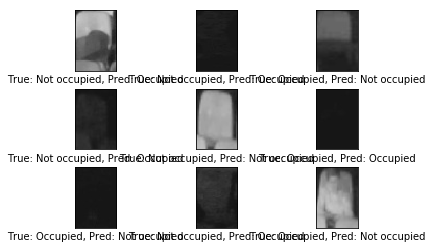

Confusion Matrix:
[[54569   296]
 [   89 13563]]


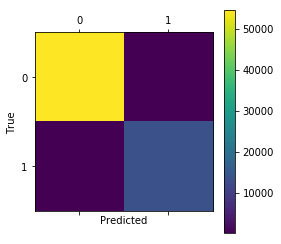

In [29]:
optimize(num_iterations=9000)

print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)